In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse RBS data from Borujeni 2016, but with the OG Supplementary data

In the previous script, I used Scott's version of the data, which turned out to be a subset of the full data.

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re
from common import count_ARN_motifs, count_ARNn, drop_subheader


top_dir = os.path.join('data', '21_analyse_RBS_data_Borujeni2')
fn = os.path.join('data', 'nar-03716-r-2016-File008.xlsx')
name_sheet = '495 mRNA dataset'

In [12]:
# Read the Excel file
excel_file = pd.ExcelFile(fn)

# Read the Broujeni 2016 sheet
df = excel_file.parse(name_sheet)

print("\nShape of dataframe:", df.shape)


Shape of dataframe: (496, 46)


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
idxs_subheaders = [df.columns.tolist().index(i) for i in df.columns if not i.startswith('Unnamed:')]
df_ids = drop_subheader(df[df.columns[:idxs_subheaders[0]]])
df_calcs1 = drop_subheader(df[df.columns[idxs_subheaders[0]:idxs_subheaders[1]]])
df_calcs2 = drop_subheader(df[df.columns[idxs_subheaders[1]:]])

In [14]:
df_full1 = pd.concat([df_ids, df_calcs1], axis=1)
df_full1['Footprint length'] = int(df.columns[idxs_subheaders[0]].split(' = ')[1].split(' ')[0])
df_full2 = pd.concat([df_ids, df_calcs2], axis=1)
df_full2['Footprint length'] = int(df.columns[idxs_subheaders[1]].split(' = ')[1].split(' ')[0])
df_full = pd.concat([df_full1, df_full2], axis=0).reset_index(drop=True)
df_full = df_full.drop(columns=[np.nan])


# ARN counts vs. predicted DG and fluorescence

In [15]:
df_full['ARN count'] = df_full['mRNA Sequence'].apply(count_ARN_motifs)
df_full['(ARN)n count'] = df_full['mRNA Sequence'].apply(count_ARNn)

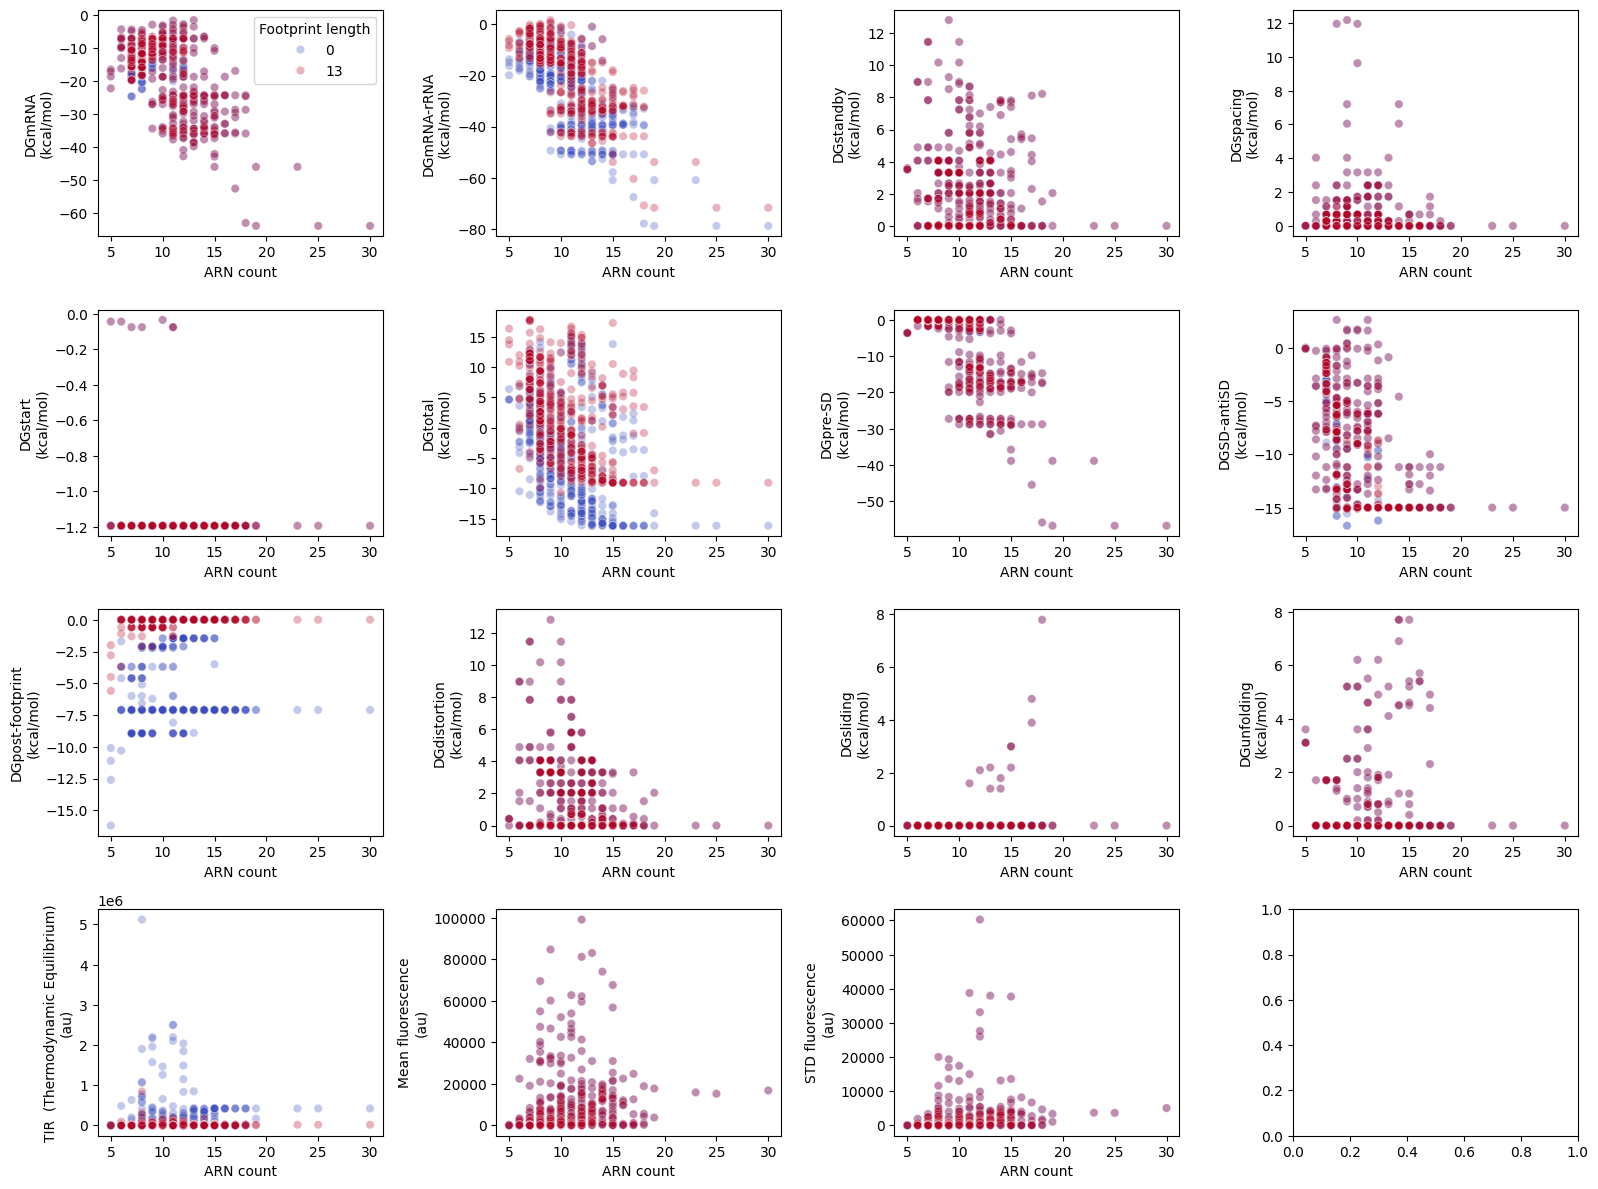

In [16]:
cols_dg = [col for col in df_full.columns if col.startswith('DG')] + [
    'TIR  (Thermodynamic Equilibrium)\n(au)', 'Mean fluorescence\n(au)', 'STD fluorescence\n(au)']
nrows = int(np.ceil(np.sqrt(len(cols_dg))))
ncols = int(np.ceil(len(cols_dg) / nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
for i, col in enumerate(cols_dg):
    sns.scatterplot(df_full, x='ARN count', y=col, hue='Footprint length', palette='coolwarm', 
                    alpha=0.3, ax=axs[i//ncols, i%ncols], legend=True if i==0 else False)
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'RBS_DG_vs_ARN_count.png'), dpi=300)

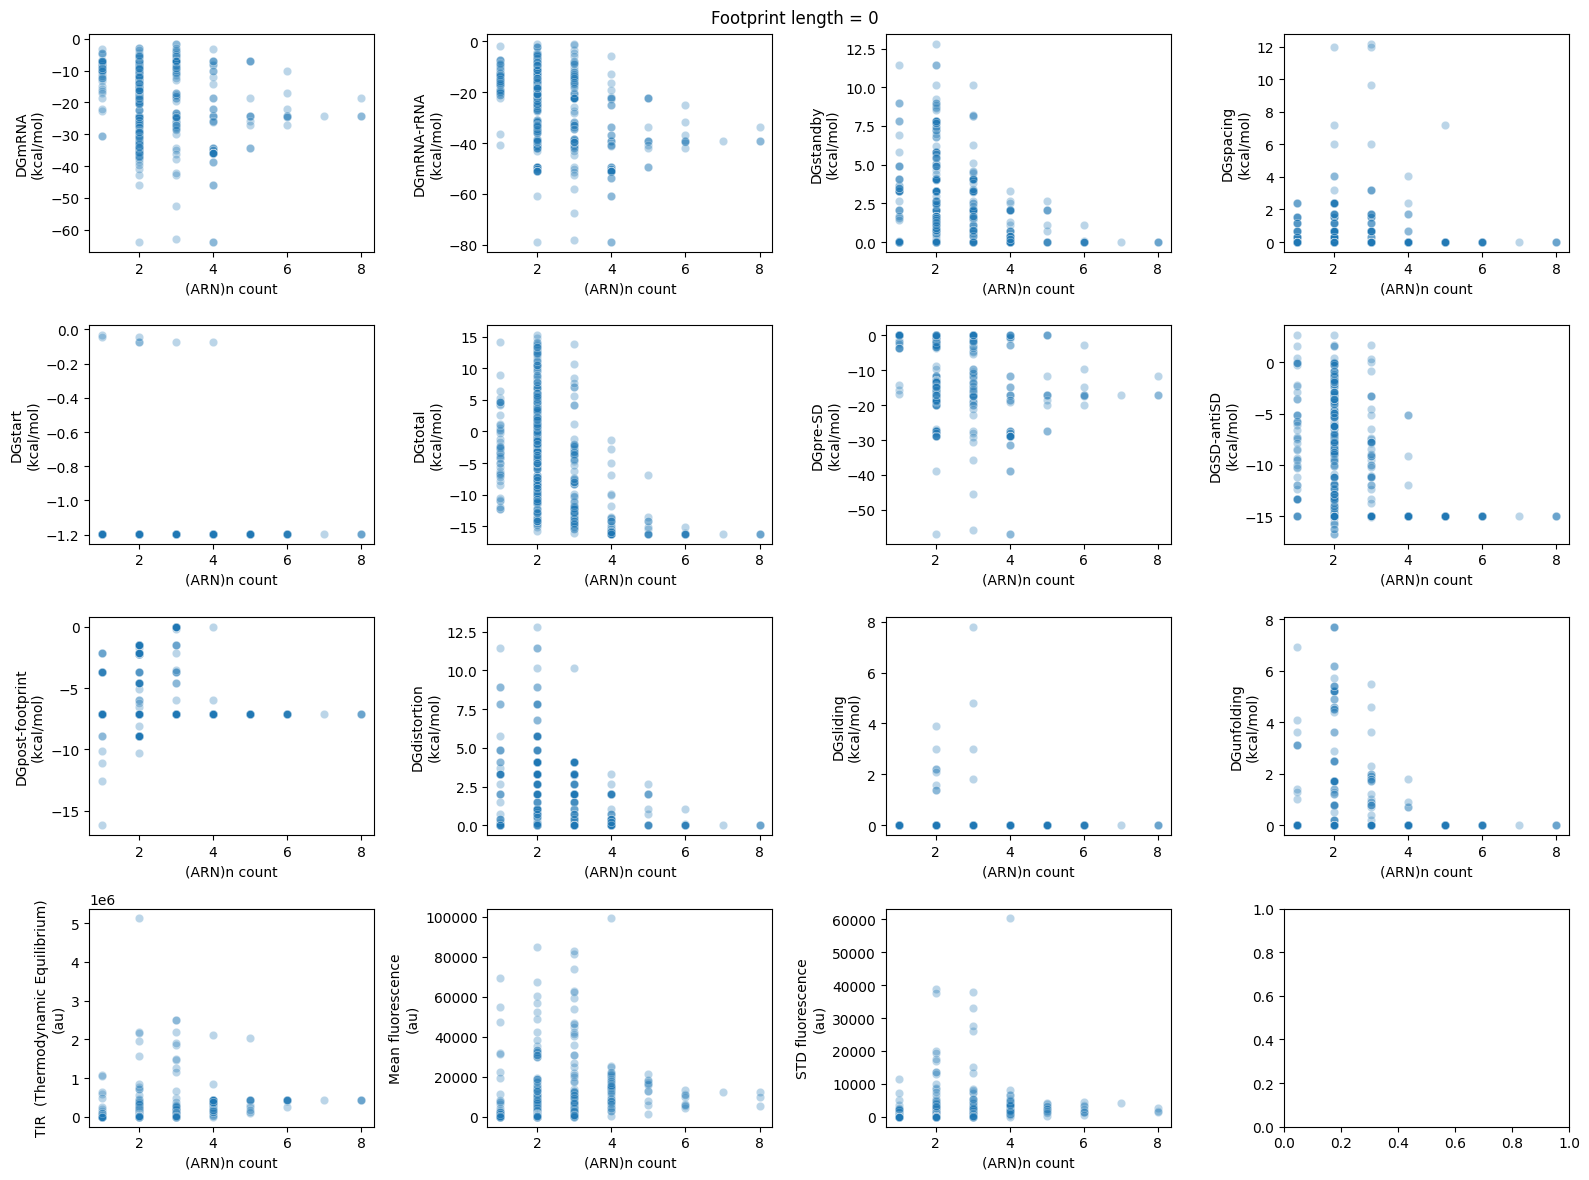

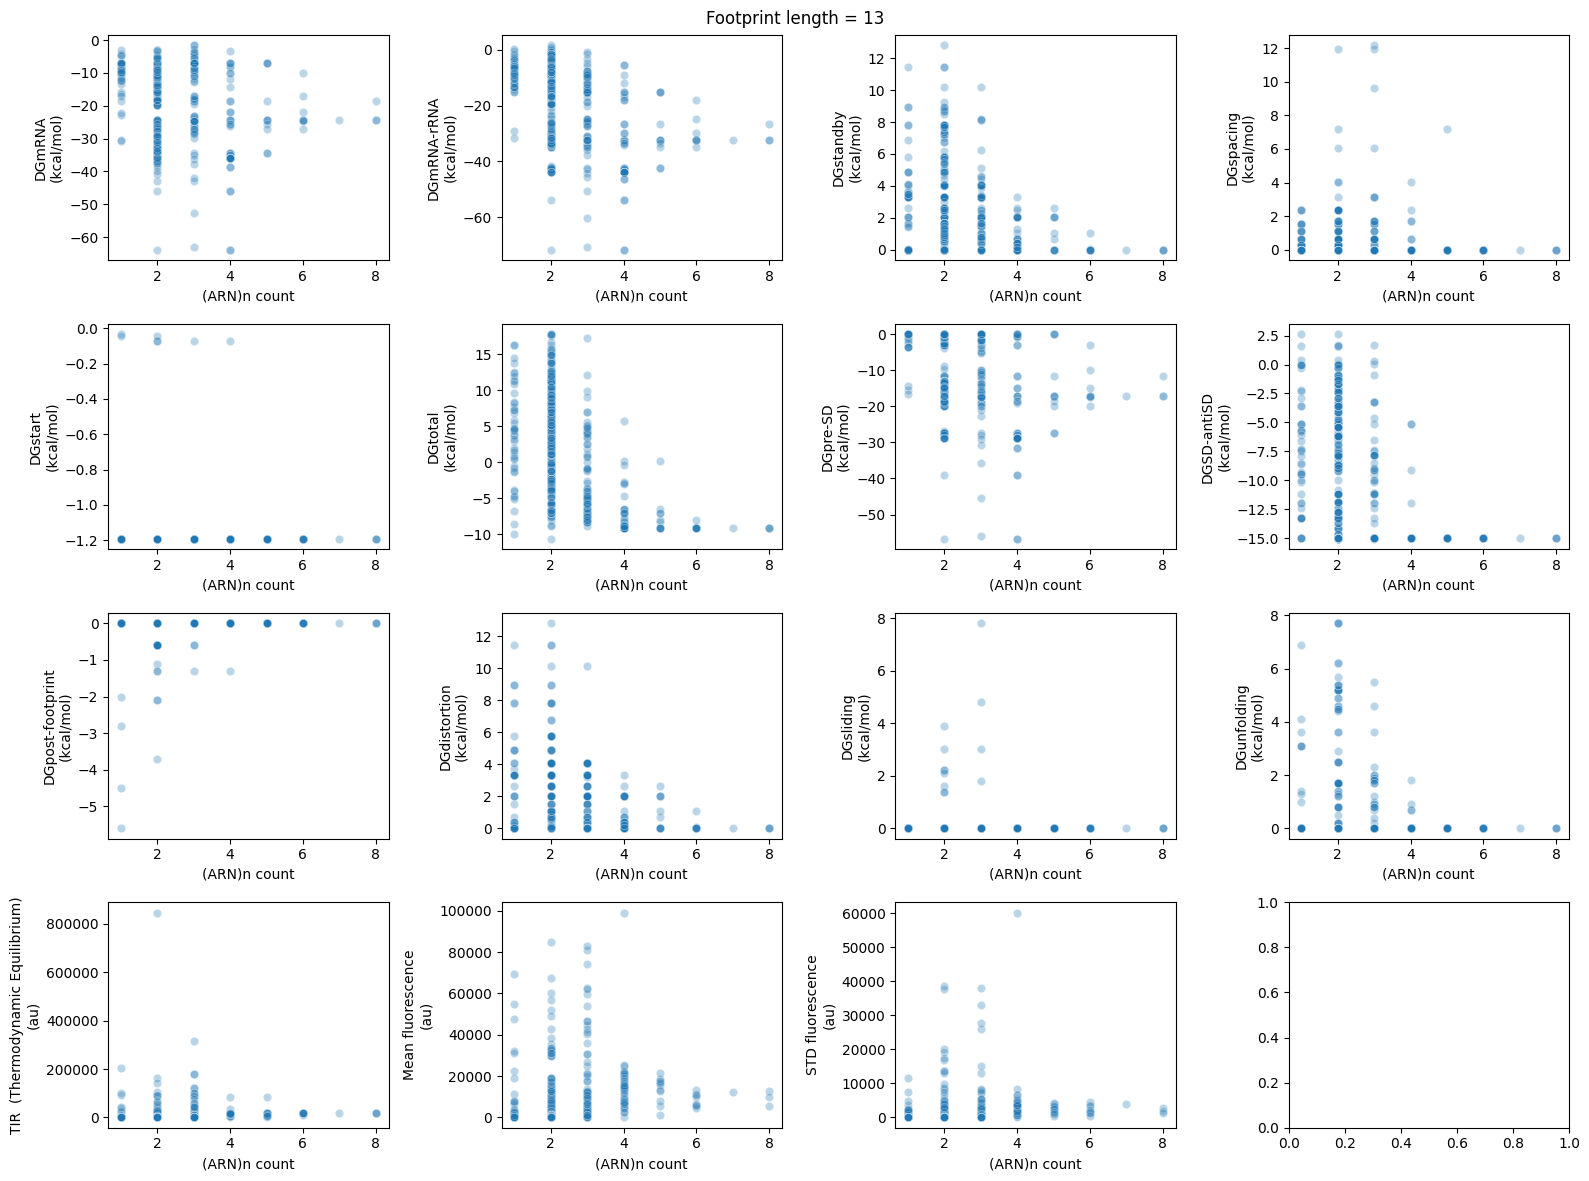

In [17]:
for fl in df_full['Footprint length'].unique():
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    for i, col in enumerate(cols_dg):
        sns.scatterplot(df_full[df_full['Footprint length'] == fl], x='(ARN)n count', y=col, 
                        alpha=0.3, ax=axs[i//ncols, i%ncols], legend=True if i==0 else False)
    plt.suptitle(f'Footprint length = {fl}')
    plt.tight_layout()
    plt.savefig(os.path.join(top_dir, f'RBS_DG_vs_ARNn_fl{fl}.png'), dpi=300)
